In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import os.path
%matplotlib inline

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.datasets import load_boston
boston_data = load_boston()
print(boston_data['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:
boston_data['data'].shape

(506, 13)

In [5]:
boston_data['target'].shape

(506,)

In [6]:
x_vals = np.array([x for x in boston_data['data']])
y_vals = np.array([x for x in boston_data['target']])

In [7]:
def norm_x_vals(x):
    x_vals_col_min = np.min(x_vals, axis=0)
    x_vals_col_max = np.max(x_vals, axis=0)
    return (x - x_vals_col_min) / (x_vals_col_max - x_vals_col_min)

In [8]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
train_x_vals = x_vals[train_indices]
test_x_vals = x_vals[test_indices]
train_y_vals = y_vals[train_indices]
test_y_vals = y_vals[test_indices]

train_x_vals = norm_x_vals(train_x_vals)
test_x_vals = norm_x_vals(test_x_vals)

In [9]:
def regression_model(train_x_vals, train_y_vals, test_x_vals, test_y_vals, N, batch_size, learning_rate, reg_type = 'linear'):
    
    ops.reset_default_graph()
    sess = tf.Session()
    
    x_data = tf.placeholder(shape=[None, train_x_vals.shape[1]], dtype=tf.float32)
    x_data_test = tf.placeholder(shape=[None, train_x_vals.shape[1]], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    A = tf.Variable(tf.random_normal(shape=[train_x_vals.shape[1],1]))
    b = tf.Variable(tf.random_normal(shape=[1,1]))
    
    model_output = tf.add(tf.matmul(x_data, A), b)
    test_output = tf.add(tf.matmul(x_data_test, A), b)
    
    if reg_type == 'linear':

        loss = tf.reduce_mean(tf.square(y_target - model_output))
        test_loss = tf.reduce_mean(tf.square(y_target_test - test_output))
        
    elif reg_type == 'deming':

        deming_numerator = tf.abs(tf.subtract(tf.add(tf.matmul(x_data, A), b), y_target))
        deming_denominator = tf.sqrt(tf.add(tf.square(A),1))
        loss = tf.reduce_mean(tf.truediv(deming_numerator, deming_denominator))
        
        test_deming_numerator = tf.abs(tf.subtract(tf.add(tf.matmul(x_data_test, A), b), y_target_test))
        test_deming_denominator = tf.sqrt(tf.add(tf.square(A),1))
        test_loss = tf.reduce_mean(tf.truediv(test_deming_numerator, test_deming_denominator))
    
    elif reg_type == 'lasso':
        
        #heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
        
        #lambda
        lasso_param = tf.constant(1.)
        lasso_loss = tf.reduce_mean(tf.abs(A))
        loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(lasso_param, lasso_loss))
        test_loss = tf.add(tf.reduce_mean(tf.square(y_target_test - test_output)), tf.multiply(lasso_param, lasso_loss))
        
    elif reg_type == 'ridge':
        #lambda
        ridge_param = tf.constant(1.)
        ridge_loss = tf.reduce_mean(tf.square(A))
        loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss))
        test_loss = tf.add(tf.reduce_mean(tf.square(y_target_test - test_output)), tf.multiply(ridge_param, ridge_loss))
        
        #regularization_param = 0.001
        
        #loss = tf.add(tf.reduce_mean(tf.square(tf.subtract(y_target, model_output))), tf.multiply(regularization_param, tf.reduce_sum(tf.square(A))))
        #test_loss = tf.add(tf.reduce_mean(tf.square(tf.subtract(y_target_test, test_output))), tf.multiply(regularization_param, tf.reduce_sum(tf.square(A))))
    elif reg_type == 'logistic':
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = model_output, labels = y_target))
        test_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = test_output, labels = y_target_test))

   
    my_opt = tf.train.GradientDescentOptimizer(learning_rate)

    train_step = my_opt.minimize(loss)
    init = tf.global_variables_initializer()
    sess.run(init)

    
    prediction = test_output
    if reg_type == 'logistic':
        prediction = tf.round(tf.sigmoid(test_output))
    
    loss_vec = []
    loss_test_vec = []
    
    predict_y_vals_vec = []
    #train_acc_vec = []
    #test_acc_vec = []

    for i in range(N):
        rand_index = np.random.choice(len(train_x_vals), size=batch_size)
        rand_x = train_x_vals[rand_index]
        rand_y = np.transpose([train_y_vals[rand_index]])
        
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss_test = 0

        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        #temp_acc_train = sess.run(accuracy, feed_dict={x_data: train_x_vals, y_target: np.transpose([train_y_vals])})
        #temp_acc_test = sess.run(accuracy, feed_dict={x_data: test_x_vals, y_target: np.transpose([test_y_vals])})
        temp_loss_test = sess.run(test_loss, feed_dict={x_data_test: test_x_vals, y_target_test: np.transpose([test_y_vals])})
        
        loss_vec.append(temp_loss)
        loss_test_vec.append(temp_loss_test)
        #train_acc_vec.append(temp_acc_train)
        #test_acc_vec.append(temp_acc_test)
        if (i+1) % 2500 == 0:
            print('Generation # {}. Train Loss: {:.2f}. Test Loss: {:.2f}'.format(i+1, temp_loss, temp_loss_test))

        #if (i+1) % 10000 == 0:
        #    predict_y_vals = sess.run(test_prediction, feed_dict={x_data_test: rand_x})
        #    predict_y_vals_vec.append(predict_y_vals)
        
    if reg_type == 'deming':
        predictions = sess.run(prediction, feed_dict={x_data_test: test_x_vals, y_target_test: np.transpose([test_y_vals])})
    else:
        predictions = sess.run(prediction, feed_dict={x_data_test: test_x_vals})                                             
    return loss_vec, loss_test_vec, predictions

In [10]:
generations = 10000
batch_size = 25
learning_rate = 0.01

## Linear regression

In [11]:
loss_linear, loss_test_linear, prediction_linear  = regression_model(train_x_vals, train_y_vals, test_x_vals, test_y_vals, generations, batch_size, learning_rate, 'linear')

Generation # 2500. Train Loss: 15.91. Test Loss: 22.77
Generation # 5000. Train Loss: 14.43. Test Loss: 18.86
Generation # 7500. Train Loss: 23.08. Test Loss: 17.55
Generation # 10000. Train Loss: 10.50. Test Loss: 17.15


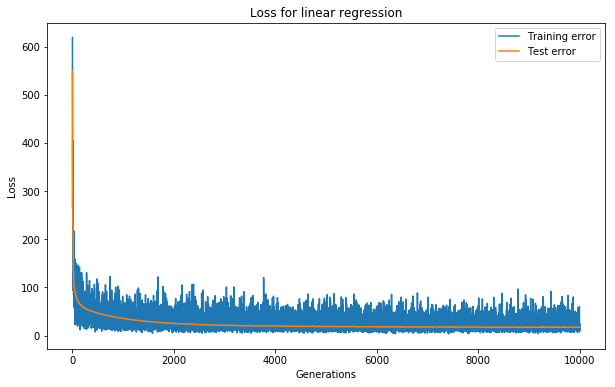

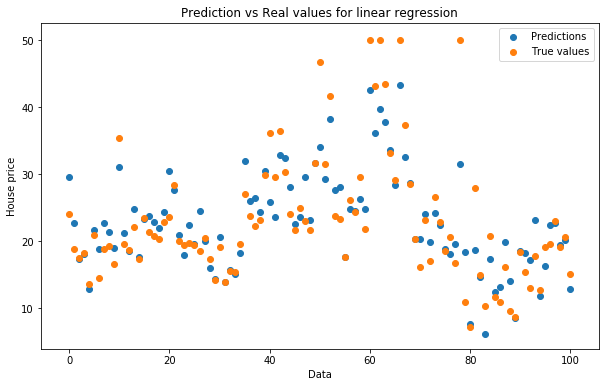

In [12]:
model_name = 'linear'

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(loss_linear, label='Training error')
plt.plot(loss_test_linear, label='Test error')

plt.ylabel('Loss')
plt.title('Loss for ' + model_name + ' regression')
plt.xlabel('Generations')
plt.legend(loc='upper right')

plt.show()

plt.scatter(range(len(test_x_vals)), prediction_linear, label='Predictions')
plt.scatter(range(len(test_x_vals)), test_y_vals, label='True values')

plt.ylabel('House price')
plt.title('Prediction vs Real values for ' + model_name +' regression')
plt.xlabel('Data')
plt.legend(loc='upper right')

plt.show()

## Deming regression

### Deming regression is a technique for fitting a straight line to two-dimensional data where both variables, X and Y, are measured with error.

In [13]:
loss_deming, loss_test_deming, prediction_deming  = regression_model(train_x_vals[:,1].reshape(len(train_x_vals),1), train_y_vals, test_x_vals[:,1].reshape(len(test_x_vals), 1), test_y_vals, generations, batch_size, learning_rate*10, 'deming')

Generation # 2500. Train Loss: 0.36. Test Loss: 0.37
Generation # 5000. Train Loss: 0.25. Test Loss: 0.26
Generation # 7500. Train Loss: 0.18. Test Loss: 0.24
Generation # 10000. Train Loss: 0.21. Test Loss: 0.23


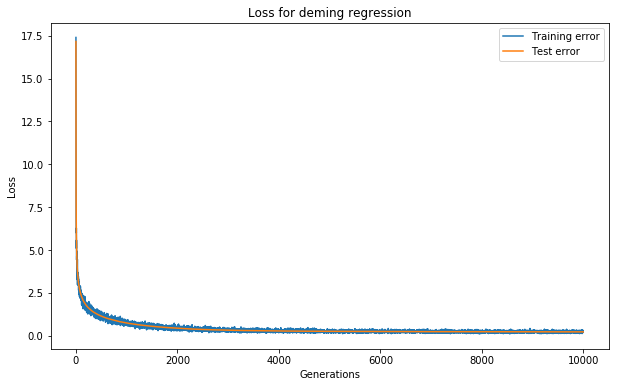

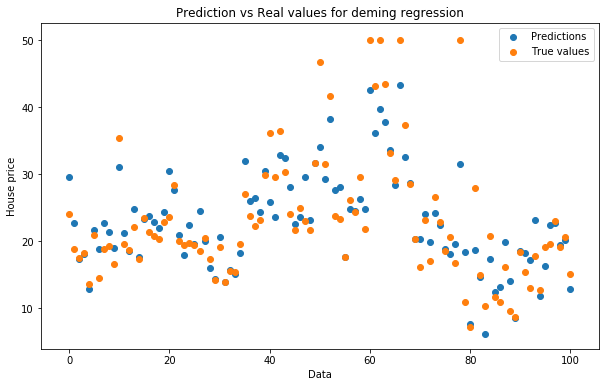

In [14]:
model_name = 'deming'

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(loss_deming, label='Training error')
plt.plot(loss_test_deming, label='Test error')

plt.ylabel('Loss')
plt.title('Loss for ' + model_name + ' regression')
plt.xlabel('Generations')
plt.legend(loc='upper right')

plt.show()

plt.scatter(range(len(test_x_vals)), prediction_linear, label='Predictions')
plt.scatter(range(len(test_x_vals)), test_y_vals, label='True values')

plt.ylabel('House price')
plt.title('Prediction vs Real values for ' + model_name + ' regression')
plt.xlabel('Data')
plt.legend(loc='upper right')

plt.show()

## Lasso regression

In [15]:
loss_lasso, loss_test_lasso, prediction_lasso  = regression_model(train_x_vals, train_y_vals, test_x_vals, test_y_vals, generations, batch_size, learning_rate, 'lasso')

Generation # 2500. Train Loss: 33.63. Test Loss: 28.45
Generation # 5000. Train Loss: 32.76. Test Loss: 25.20
Generation # 7500. Train Loss: 49.79. Test Loss: 24.64
Generation # 10000. Train Loss: 14.29. Test Loss: 24.41


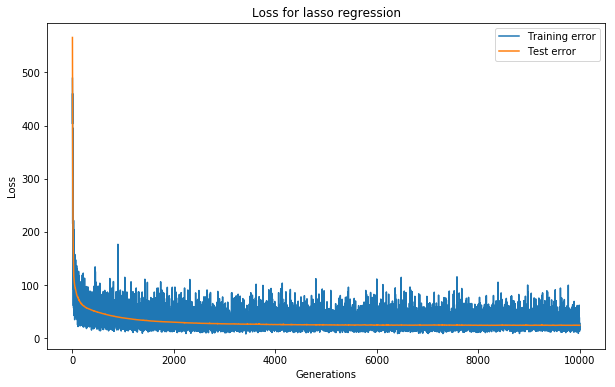

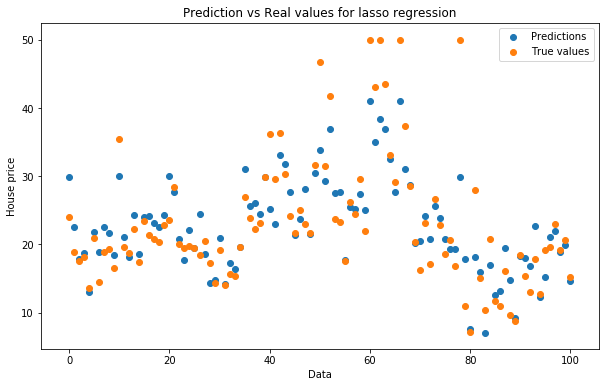

In [16]:
model_name = 'lasso'

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(loss_lasso, label='Training error')
plt.plot(loss_test_lasso, label='Test error')

plt.ylabel('Loss')
plt.title('Loss for ' + model_name + ' regression')
plt.xlabel('Generations')
plt.legend(loc='upper right')

plt.show()

plt.scatter(range(len(test_x_vals)), prediction_lasso, label='Predictions')
plt.scatter(range(len(test_x_vals)), test_y_vals, label='True values')

plt.ylabel('House price')
plt.title('Prediction vs Real values for ' + model_name + ' regression')
plt.xlabel('Data')
plt.legend(loc='upper right')

plt.show()

## Ridge regression

In [17]:
loss_ridge, loss_test_ridge, prediction_ridge  = regression_model(train_x_vals, train_y_vals, test_x_vals, test_y_vals, generations, batch_size, learning_rate, 'ridge')

Generation # 2500. Train Loss: 40.39. Test Loss: 52.80
Generation # 5000. Train Loss: 93.04. Test Loss: 51.83
Generation # 7500. Train Loss: 89.49. Test Loss: 51.93
Generation # 10000. Train Loss: 43.09. Test Loss: 51.86


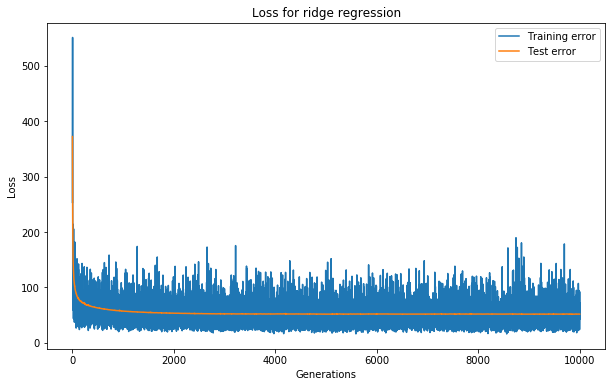

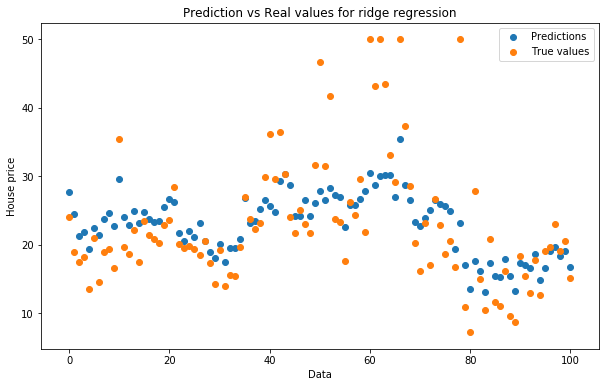

In [18]:
model_name = 'ridge'

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(loss_ridge, label='Training error')
plt.plot(loss_test_ridge, label='Test error')

plt.ylabel('Loss')
plt.title('Loss for ' + model_name + ' regression')
plt.xlabel('Generations')
plt.legend(loc='upper right')

plt.show()

plt.scatter(range(len(test_x_vals)), prediction_ridge, label='Predictions')
plt.scatter(range(len(test_x_vals)), test_y_vals, label='True values')

plt.ylabel('House price')
plt.title('Prediction vs Real values for ' + model_name + ' regression')
plt.xlabel('Data')
plt.legend(loc='upper right')

plt.show()

## Logistic regression

In [19]:
np.mean(train_y_vals)

22.418024691358024

In [20]:
np.mean(test_y_vals)

22.993069306930682

In [21]:
train_y_vals_logistic = np.array([1 if x > np.mean(train_y_vals) else 0 for x in train_y_vals ])
test_y_vals_logistic = np.array([1 if x > np.mean(train_y_vals) else 0 for x in test_y_vals ])

In [22]:
loss_logistic, loss_test_logistic, prediction_logistic  = regression_model(train_x_vals, train_y_vals_logistic, test_x_vals, test_y_vals_logistic, generations, batch_size, learning_rate*10, 'logistic')

Generation # 2500. Train Loss: 0.45. Test Loss: 0.31
Generation # 5000. Train Loss: 0.43. Test Loss: 0.27
Generation # 7500. Train Loss: 0.28. Test Loss: 0.25
Generation # 10000. Train Loss: 0.41. Test Loss: 0.25


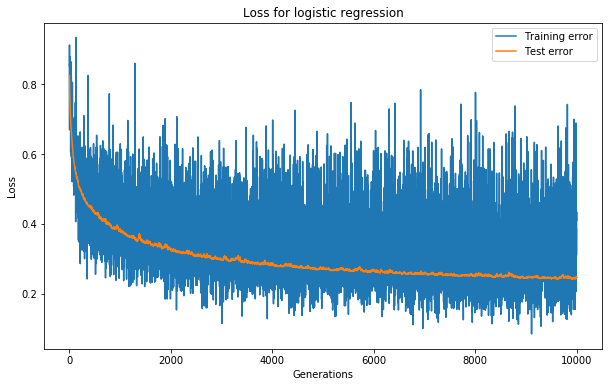

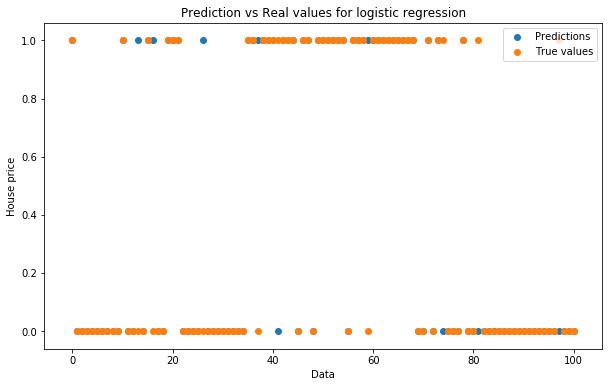

Accuracy:  0.5158317811979217


In [23]:
model_name = 'logistic'

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(loss_logistic, label='Training error')
plt.plot(loss_test_logistic, label='Test error')

plt.ylabel('Loss')
plt.title('Loss for ' + model_name + ' regression')
plt.xlabel('Generations')
plt.legend(loc='upper right')

plt.show()

plt.scatter(range(len(test_x_vals)), prediction_logistic, label='Predictions')
plt.scatter(range(len(test_x_vals)), test_y_vals_logistic, label='True values')

plt.ylabel('House price')
plt.title('Prediction vs Real values for ' + model_name + ' regression')
plt.xlabel('Data')
plt.legend(loc='upper right')

plt.show()

acc_logistic = np.mean(prediction_logistic == test_y_vals_logistic)
print('Accuracy: ', acc_logistic)

### Not good -- need to improve later

In [ ]:
corr_x_y = [np.cov(x, y_vals)[0][1] for x in x_vals.T]
m = max(corr_x_y)
[i for i, j in enumerate(corr_x_y) if j == m]